## Exploratory Data Analysis

- Antibody usage by checkpoint
- Interface length and residue frequency
- Epitope overlap: common vs. unique

In [9]:
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random
import os
from scipy.stats import zscore
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import requests
from Bio.PDB import PDBParser, NeighborSearch
from propy.PseudoAAC import GetPseudoAAC, _Hydrophobicity, _hydrophilicity, _residuemass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import glob
from propy.PseudoAAC import GetPseudoAAC, _Hydrophobicity, _hydrophilicity, _residuemass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [4]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]


# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]


combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)


shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

## PDB IDs pro Checkpoint geordnet runterladen

In [4]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Ordner erstellen. Der loop geht über die jeweiligen pdbs der Checkpoints
for checkpoint in checkpoints:
    save_folder = f'pdbs/{checkpoint}' # Define save directory
    os.makedirs(save_folder, exist_ok=True) # make new directory with name above if doesn't exist
    for pdb_id in pdb_ids[checkpoint]: 
        pdb_id = pdb_id.lower()
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        if response.status_code == 200:
            with open(os.path.join(save_folder, f"{pdb_id}.pdb"), "w") as f:
                f.write(response.text)
            print(f"Downloaded: {pdb_id}.pdb")
        else:
            print(f"Failed to download: {pdb_id}.pdb (status code: {response.status_code})") 

Downloaded: 8u31.pdb
Downloaded: 8u32.pdb
Downloaded: 8gy5.pdb
Downloaded: 7wsl.pdb
Downloaded: 8as0.pdb
Downloaded: 5ggs.pdb
Downloaded: 7cgw.pdb
Downloaded: 5jxe.pdb
Downloaded: 5ggr.pdb
Downloaded: 5b8c.pdb
Downloaded: 6jjp.pdb
Downloaded: 5wt9.pdb
Downloaded: 7bxa.pdb
Downloaded: 7e9b.pdb
Downloaded: 7wvm.pdb
Downloaded: 7cu5.pdb
Downloaded: 6k0y.pdb
Downloaded: 6xkr.pdb
Downloaded: 8rpb.pdb
Downloaded: 5xj4.pdb
Downloaded: 7yds.pdb
Downloaded: 5ggt.pdb
Downloaded: 5grj.pdb
Downloaded: 5x8l.pdb
Downloaded: 5x8m.pdb
Downloaded: 5xxy.pdb
Downloaded: 9dq3.pdb
Downloaded: 9dq4.pdb
Downloaded: 9dq5.pdb
Downloaded: 5xj3.pdb
Downloaded: 6rp8.pdb
Downloaded: 7dv4.pdb
Downloaded: 5ggv.pdb
Downloaded: 7su0.pdb
Downloaded: 5tru.pdb
Downloaded: 6xy2.pdb
Downloaded: 7su1.pdb
Downloaded: 7elx.pdb
Downloaded: 8tui.pdb
Downloaded: 7tzh.pdb
Downloaded: 7tzg.pdb
Downloaded: 6txz.pdb


## Define interface
- Analysieren der Protein-Protein-Interaktion zwischen einem Antikörper und einem Antigen
- Identifizieren der Residuen an der Grenzfläche (innerhalb 5 A). 
- (Bidirektional, weil nicht garantiert ist, dasss beide Richtungen symmetrisch sind)

In [16]:
def analyze_interface_residues(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0): # pdb_path: Pfad zur PDB-Datei mit 3D-Struktur
    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True) # Die PDB-Datei wird geladen und das erste Modell ausgewählt
    structure = parser.get_structure(pdb_id, pdb_path)
    model = structure[0]

    ab_chains = [heavy_chain, light_chain] # Ketten-IDs definieren
    ag_chain = antigen_chain

    ab_atoms, ag_atoms = [], [] # Atome extrahieren. Werden als Liste gesammelt.
    ab_residues, ag_residues = set(), set() 

    for chain in model: # Loop über alle Ketten im Modell. (Sammeln alle Atome, die zu den relevanten Ketten im Molekül gehören (ab (heavy und light) und ag)
        if chain.id in ab_chains: # Wenn Kette Teil des ab ist (heavy oder light)
            ab_atoms.extend(chain.get_atoms()) # Alle Atome dieser Kette in die ab_atoms-Liste
        elif chain.id == ag_chain: # Wenn Kette das ag ist
            ag_atoms.extend(chain.get_atoms()) # Alle Atome dieser Kette in die ag_atoms-Liste

    ns = NeighborSearch(ab_atoms + ag_atoms) # Suche nach Atomen in der Nähe

    for atom in ab_atoms: # Interface-Residuen identifizieren: Für jedes ab-Atom, finde ag-Atome innerhalb von 5A. Loop geht über alle Atome die im file sind
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id == ag_chain:
                ag_residues.add(res)

    for atom in ag_atoms: # Das selbe wie oben für ag Atome: finde nahe ag Residuen
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)
    rows = []

    ab_freq = Counter(res.resname for res in ab_residues) # Count frequency, residues die am häufigsten vorkommen nehmen und alle daten die innerhalb von 5A bekommen
    ag_freq = Counter(res.resname for res in ag_residues)

    for res in ab_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antibody",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ab_freq[res.resname]
        })

    for res in ag_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antigen",
            "residue_name": res.resname,
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ag_freq[res.resname]
        })

    return rows # Gibt eine Liste aller Grenzflächen-Residuen mit Daten zurück



def analyze_epitope_residues(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0):
    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_path)
    model = structure[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain = antigen_chain

    ab_atoms, ag_atoms = [], []
    epitope_residues = set()

    for chain in model:
        if chain.id in ab_chains:
            for residue in chain:
                if residue.get_resname() != "HOH":
                    ab_atoms.extend(residue.get_atoms())
        elif chain.id == ag_chain:
            for residue in chain:
                if residue.get_resname() != "HOH":
                    ag_atoms.extend(residue.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    for atom in ag_atoms:
        for neighbor in ns.search(atom.coord, cutoff):
            res = neighbor.get_parent()
            if res.get_resname() != "HOH" and res.get_parent().id in ab_chains:
                epitope_residues.add(atom.get_parent())
                break  # Only need to add once per antigen residue

    ag_freq = Counter(res.get_resname() for res in epitope_residues)

    rows = []
    for res in epitope_residues:
        rows.append({
            "pdb_id": pdb_id,
            "chain_id": res.get_parent().id,
            "partner_type": "antigen",
            "residue_name": res.get_resname(),
            "residue_number": res.id[1],
            "residue_id": f"{res.id[1]}{res.id[2].strip()}",
            "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
            "interface_distance": cutoff,
            "residue_frequency": ag_freq[res.get_resname()]
        })

    return rows

## Speichern der Residue Daten in csv

In [22]:
current_checkpoint = 'tim3' # wechseln 
folder_path = f"structures/{current_checkpoint}"
ckpt_ids = os.listdir(folder_path)
all_interface_rows = []

for ckpt_id in ckpt_ids:
    pdb_path = os.path.join(folder_path, ckpt_id) #structures/pd1/5b8c.pdb 
    pdb_id = ckpt_id.replace(".pdb", "") #5b8c

    try: #wenn pdbid existiert, dann gibt es die wer
        H = tim3[tim3['pdb'] == pdb_id]['Hchain'].values[0] # wechseln 
        L = tim3[tim3['pdb'] == pdb_id]['Lchain'].values[0] # wechseln
        A = tim3[tim3['pdb'] == pdb_id]['antigen_chain'].values[0] # wechseln

        rows = analyze_epitope_residues(pdb_path, H, L, A) #gibt werte, die wir für die funktion brauchen 
        all_interface_rows.extend(rows) #verknüpft alle reihen

    except Exception as e: #wenn es kein pdb oder kein file
        print(f"Error with {ckpt_id}: {e}")

#Save full long-format table
df_out = pd.DataFrame(all_interface_rows) #in df umwandeln
output_folder = f"data/{current_checkpoint}" #definiert output für csv
os.makedirs(output_folder, exist_ok=True) # make Ordner, falls nciht existiert


df_out.to_csv(f"{output_folder}/{current_checkpoint}_epitope_residues.csv", index=False) #erstellt ein csv (excel) file
print(f"Saved detailed data to {current_checkpoint}_epitope_residues.csv")


# Create pivot summary
df_pivot = df_out.groupby(['residue_name', 'pdb_id'])['residue_name'].count().unstack(fill_value=0) #wandelt die pdb ids in spalten um und berechnet die Häufigkeit der residuen pro pdb id. unstack fill 0 setzt eine 0, wenn es nicht vorkommt
df_pivot.to_csv(f"{output_folder}/{current_checkpoint}_epitope_residue_frequencies_pivot.csv")

print(f"Saved pivot summary to {current_checkpoint}_epitope_residue_frequencies_pivot.csv")

Error with 7cgw_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 6txz_epitope.pse: index 0 is out of bounds for axis 0 with size 0
Error with 6txzparatope.pse: index 0 is out of bounds for axis 0 with size 0
Saved detailed data to tim3_epitope_residues.csv
Saved pivot summary to tim3_epitope_residue_frequencies_pivot.csv


## Heatmaps

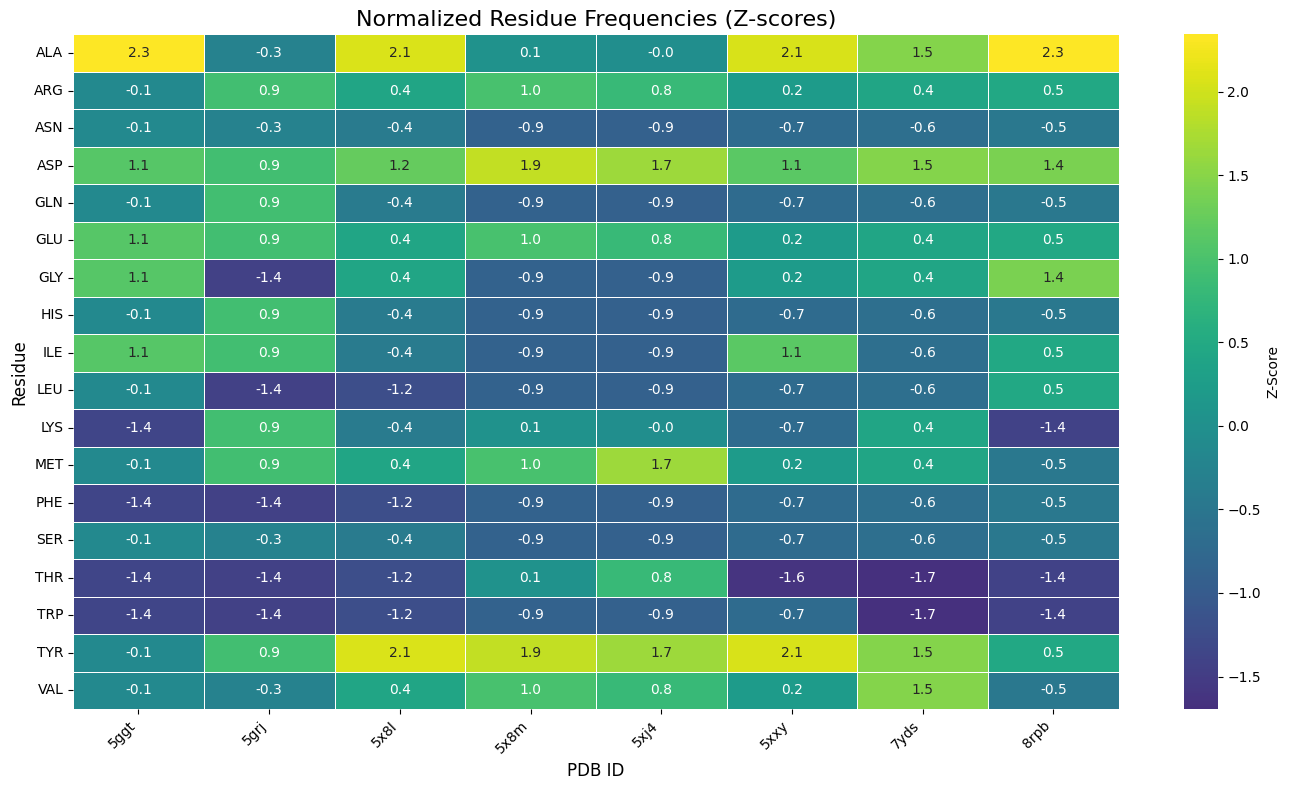

In [ ]:
# Load pivoted frequency table
checkpoints = ['pd1', 'pdl1', 'tim3', 'kir', 'lag3', 'tim3']

for ckpt in checkpoints:
    df = pd.read_csv(f"data/{ckpt}/{ckpt}_epitope_residue_frequencies_pivot.csv", index_col=0)

    # Z-score across all values
    df_z = df.apply(zscore, axis=0)

    plt.figure(figsize=(14, 8))

    sns.heatmap(
        df_z,
        cmap="viridis", #Farbe
        center=0,
        annot=True,
        fmt=".1f",
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "Z-Score"}
    )

    plt.title("Normalized Residue Frequencies (Z-scores)", fontsize=16)
    plt.ylabel("Residue", fontsize=12)
    plt.xlabel("PDB ID", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    # plt.savefig(f"plots/{variable}_heatmap.pdf", bbox_inches = "tight")
    plt.show()

# Mean heatmap values

In [8]:
checkpoints = ['pd1', 'pdl1', 'ctla4', 'kir', 'lag3', 'tim3']
for checkpoint in checkpoints:    
    read_folder = f'data/{checkpoint}/{checkpoint}_residue_frequencies_pivot.csv'

    df= pd.read_csv(read_folder, index_col=0)
    df['mean'] = df.mean(axis = 1) #berechnet mittelwert pro zeile
    df.to_csv(read_folder, sep = ',')

Bar plot: Durchschnittliche Anzahl der Aminosäuren der jeweiligen Checkpoints

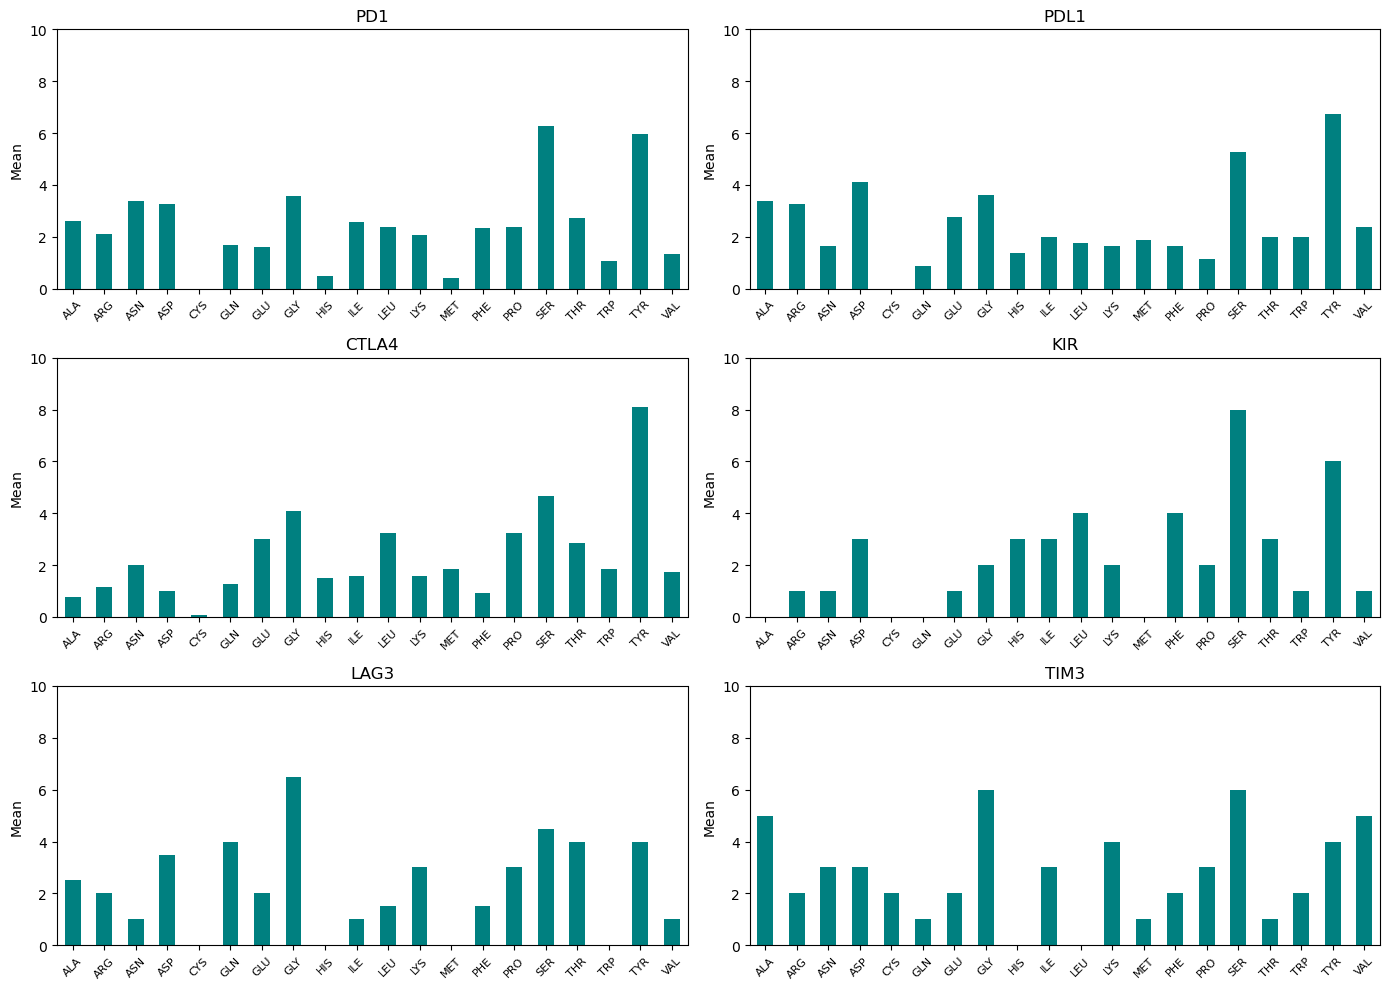

In [ ]:
all_residues = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
    'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL' #Liste aller Aminosäuren, die im Plot enthalten sein sollen
]

fig, axes = plt.subplots(3, 2, figsize=(14, 10)) #Erstellt ein 3x2-Gitter von Subplots für die Visualisierung
axes = axes.flatten()

for i, cp in enumerate(checkpoints):
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # Adds missing residues with NaN
        ax = axes[i]
        df['mean'].plot(kind='bar', ax=ax, color='teal')
        ax.set_title(f'{cp.upper()}')
        ax.set_ylim(0, 10)
        ax.set_xlabel('')
        ax.set_ylabel('Mean')
        ax.tick_params(axis='x', labelrotation=45, labelsize=8)

# Remove any unused subplots
for j in range(len(checkpoints), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(f"plots/checkpoint_AA_freq_barplot.pdf")
plt.show()

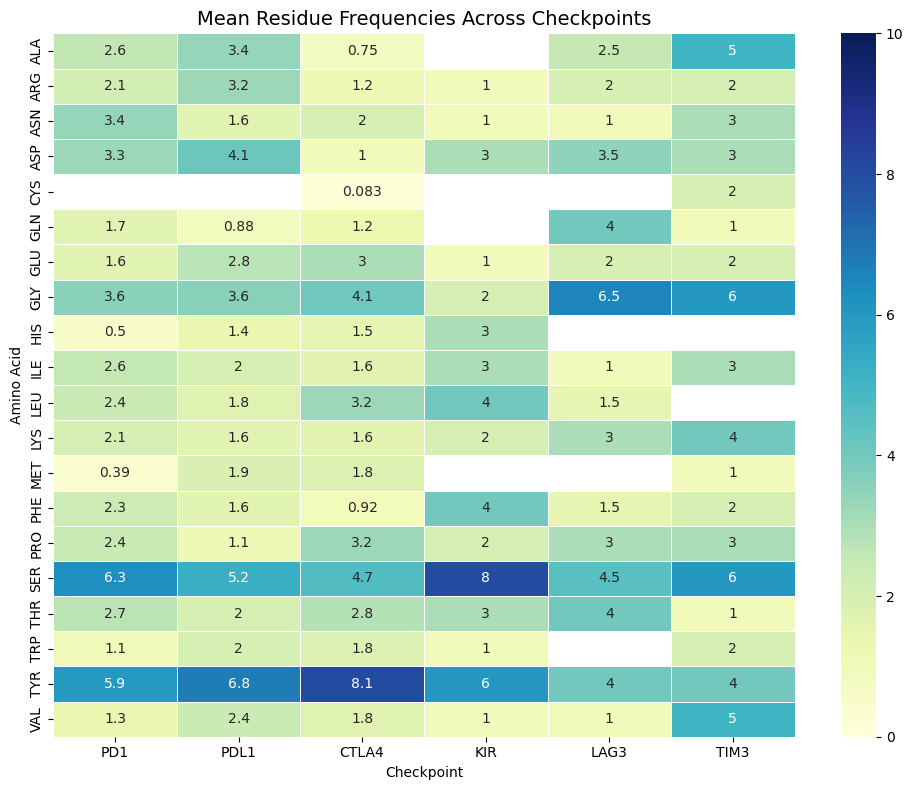

In [ ]:
heatmap_data = pd.DataFrame(index=all_residues)

for cp in checkpoints:
    file_path = f'data/{cp}/{cp}_residue_frequencies_pivot.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
        df = df.reindex(all_residues)  # ensure consistent order
        heatmap_data[cp.upper()] = df['mean']

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", vmin=0, vmax=10, linewidths=0.5)
plt.title("Mean Residue Frequencies Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint")
plt.ylabel("Amino Acid")
plt.tight_layout()
# plt.savefig("plots/checkpoint_AA_freq_heatmap.pdf", dpi=300)
plt.show()


## Aminosäurensequenzen den Checkpoints zuzuordnen
- Versuch (hat noch nicht funktioniert - es gibt nur 8)
- Mittel pseudoAAC (Optionen gegoogelt)

In [6]:
three_to_one = {
    'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C',
    'GLU':'E','GLN':'Q','GLY':'G','HIS':'H','ILE':'I',
    'LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P',
    'SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'
}

AAP = [_Hydrophobicity, _hydrophilicity, _residuemass]

def analyze_interface_and_pseaac(pdb_path, heavy_chain, light_chain, antigen_chain, cutoff=5.0):

    lamda = 10
    weight = 0.05

    pdb_id = os.path.basename(pdb_path).replace(".pdb", "")
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure(pdb_id, pdb_path)
    model = struct[0]

    ab_chains = [heavy_chain, light_chain]
    ag_chain_id = antigen_chain

    ab_atoms, ag_atoms = [], []
    ab_residues, ag_residues = set(), set()

    for chain in model:
        if chain.id in ab_chains:
            ab_atoms.extend(chain.get_atoms())
        elif chain.id == ag_chain_id:
            ag_atoms.extend(chain.get_atoms())

    ns = NeighborSearch(ab_atoms + ag_atoms)

    # Identify antigen interface residues
    for atom in ab_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id == ag_chain_id:
                ag_residues.add(res)
    # Identify antibody interface residues
    for atom in ag_atoms:
        for neigh in ns.search(atom.coord, cutoff):
            res = neigh.get_parent()
            if res.get_parent().id in ab_chains:
                ab_residues.add(res)

    # Prepare summary rows
    rows = []
    ab_freq = Counter(res.resname for res in ab_residues)
    ag_freq = Counter(res.resname for res in ag_residues)

    for res_set, freq_dict, partner in [
        (ab_residues, ab_freq, "antibody"),
        (ag_residues, ag_freq, "antigen")
    ]:
        for res in res_set:
            rows.append({
                "pdb_id": pdb_id,
                "chain_id": res.get_parent().id,
                "partner_type": partner,
                "res_name": res.resname,
                "res_num": res.id[1],
                "res_id": f"{res.id[1]}{res.id[2].strip()}",
                "chain_pair": f"{heavy_chain}{light_chain}-{antigen_chain}",
                "distance_cutoff": cutoff,
                "frequency": freq_dict[res.resname]
            })

    # Build the antigen epitope sequence (ordered)
    iface_ag = sorted(ag_residues, key=lambda r: r.id[1])
    epitope_seq = ''.join(three_to_one.get(res.resname, 'X') for res in iface_ag)

#    Remove unknowns:
    clean_seq = epitope_seq.replace('X', '')
    epitope_seq = clean_seq

    # Compute PseAAC for the epitope sequence
    pseaac_features = {}
    if len(epitope_seq) >= lamda + 1:
        pseaac_features = GetPseudoAAC(epitope_seq, lamda=lamda, weight=weight, AAP=AAP)
    else:
        print(f"{pdb_id}: epitope too short ({len(epitope_seq)} < {lamda+1})")
        pseaac_features = {}

    return rows, epitope_seq, pseaac_features

Label counts: Counter({0: 22, 1: 17})
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.75      1.00      0.86         3

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8

Total usable samples: 39
PD-1 samples: 17
Other samples: 22
Mean accuracy: 0.90 ± 0.20


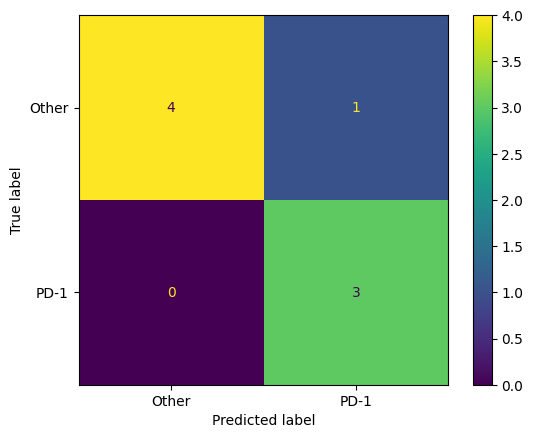

In [7]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']
target_checkpoint = "PD-1"


all_rows = []
feature_dicts = [] # here are pseaac results saved
labels = [] # which checkpoint they bind to --> in this case should all be pd1

for checkpoint in checkpoints:
    pdb_dir = os.path.join("pdbs", checkpoint)
    for pdb_file in os.listdir(pdb_dir):
        if not pdb_file.endswith(".pdb"):
            continue

        pdb_path = os.path.join(pdb_dir, pdb_file)
        pdb_id = os.path.splitext(pdb_file)[0]

        matches = shuffled_df[shuffled_df['pdb'] == pdb_id]
        if matches.empty:
            print(f"WARNING: {pdb_id} from {pdb_path} not found in DataFrame — skipping")
            continue

        row = matches.iloc[0]
        H, L, A = row['Hchain'], row['Lchain'], row['antigen_chain']
        rows, seq, pseaac = analyze_interface_and_pseaac(pdb_path, H, L, A)

        if not pseaac:
            print(f"Skipping {pdb_id} from {pdb_path}: epitope_seq='{seq}', length={len(seq)}, pseaac empty")
            continue

        ag_freq = {f"{aa}_freq": 0 for aa in three_to_one.values()}
        for r in rows:
            if r["partner_type"] == "antigen":
                aa = three_to_one.get(r["res_name"], None)
                if aa:
                    ag_freq[f"{aa}_freq"] += 1

        # feature_dicts.append({**pseaac, **ag_freq}) #pseaac and frequency considered
        feature_dicts.append(ag_freq)
        labels.append(1 if checkpoint == target_checkpoint else 0)
        all_rows.extend(rows)

# Summary of class distribution
print(f"Label counts: {Counter(labels)}")

# Build DataFrame
df = pd.DataFrame(feature_dicts)
y = labels
X = df

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train logistic regression
model = LogisticRegression(solver="lbfgs", max_iter=500)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix --> [0][0] = TN, [0][1] = FP, [1][0] = FN, [1][1] = TP
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "PD-1"])
disp.plot()
print(f"Total usable samples: {len(feature_dicts)}")
print(f"PD-1 samples: {labels.count(1)}")
print(f"Other samples: {labels.count(0)}")

scores = cross_val_score(model, X, y, cv=15)
print(f"Mean accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


plt.show()

# Clustering/PCA using only frequencies

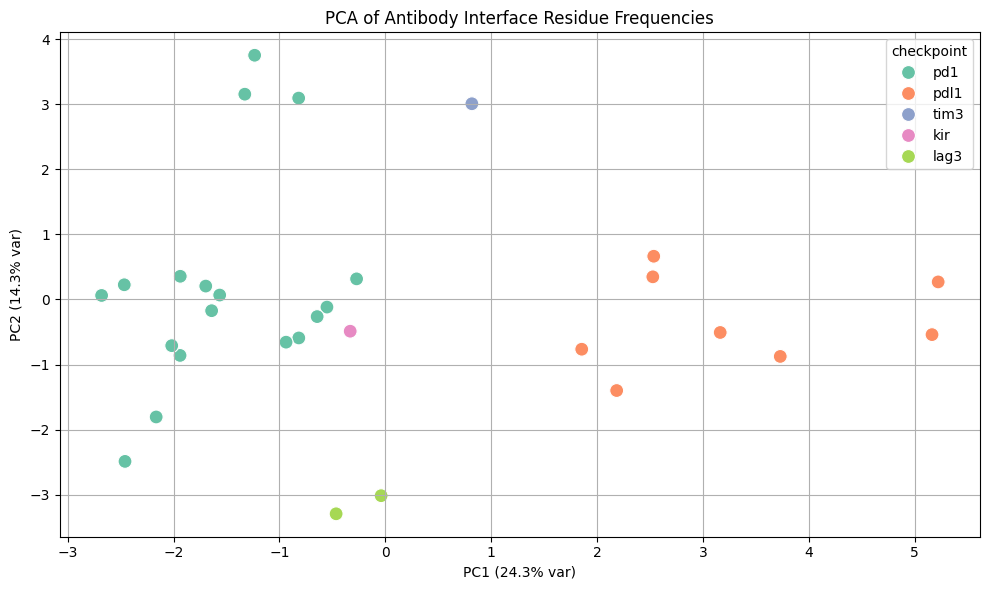

In [15]:
# 1-letter code map
three_to_one = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLN": "Q", "GLU": "E", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}
aa_list = list(three_to_one.values())

data = []
labels = []

# Loop over all 6 checkpoint folders or CSV files --> PARATOPE
checkpoints = ['pd1', 'pdl1', 'tim3', 'kir', 'lag3', 'tim3']
for checkpoint in checkpoints:
    csv_path = f"data/{checkpoint}/{checkpoint}_interface_residues.csv"  
    df = pd.read_csv(csv_path)
    
    for pdb_id, group in df.groupby("pdb_id"):
        antibody_residues = group[group["partner_type"] == "antigen"] #change antibody to antigen for epitope
        aa_counts = Counter()

        for resname in antibody_residues["residue_name"]:
            aa = three_to_one.get(resname)
            if aa:
                aa_counts[aa] += 1

        # Normalize to relative frequency
        total = sum(aa_counts.values())
        aa_freqs = {f"{aa}_freq": aa_counts.get(aa, 0) / total if total else 0 for aa in aa_list}

        data.append(aa_freqs)
        labels.append(checkpoint)

# Create DataFrame
df_features = pd.DataFrame(data)
df_features["checkpoint"] = labels

# Standardize features
X = df_features.drop("checkpoint", axis=1)
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_features["PC1"] = X_pca[:, 0]
df_features["PC2"] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_features, x="PC1", y="PC2", hue="checkpoint", palette="Set2", s=100)
plt.title("PCA of Antibody Interface Residue Frequencies")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True)
plt.tight_layout()
plt.show()